In [77]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
df = pd.read_excel('C:/Users/s/Desktop/금융빅데이터분석학/TP2data.xlsx')

df.tail(5)

,DATE,Inflation Rate,Unemployment Rate,Total Assets,MORTGAGE30US,Industrial Production,Personal Consumption Expenditures,Personal Saving Rate,Composite Leading Indicator
215,2020-12-01,1.915909,6.7,7319010.80,2.6840,98.3349,14451.1,14.2,1
216,2021-01-01,2.081579,6.3,7372161.25,2.7350,99.3189,14938.0,20.6,1
217,2021-02-01,2.180000,6.2,7500084.00,2.8100,96.3932,14789.7,14.7,1
218,2021-03-01,2.275217,6.0,7647908.20,3.0825,98.4744,15480.1,27.7,1
219,2021-04-01,2.349545,6.1,7775974.00,3.0600,99.0122,15560.3,14.9,1


In [79]:
x_train = df.iloc[0:209, 1:8].values  # from 2003.1m~2020.4m
y_train = df.iloc[0:209, [-1]].values
#x_train.tail()
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
print(x_train.shape, y_train.shape)

x_test = df.iloc[209:222, 1:8].values  # from 2020.5m~2021.4m
y_test = df.iloc[209:222, [-1]].values
#print(x_test.tail())
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

(209, 7) (209, 1)


### MinMaxScaler로 data normalize

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### Parameters 설정

In [81]:
# dataset parameters
nb_classes  = y_train.shape[1] # 1; 종속변수의 개수
nb_features = x_train.shape[1] # the number of variables 7; 독립변수의 개수
print(nb_classes, nb_features)

n_train = x_train.shape[0] # the number of sample 209
n_test  = x_test.shape[0]  # the number of sample 12
print(n_train, n_test)

# training HyperParameters
learning_rate  = 0.01
training_steps = 20001
display_step   = 2000

# network hyperparameters
n_hidden1 = 7 # 1st layer number of neurons
n_output1 = 1

1 7
209 11


### 초기값 셋업시키기

In [82]:
# define weights as a dictionary
tf.random.set_seed(2021)
"""
weights = {
    'h1'  : tf.Variable(tf.random.normal([nb_features, n_hidden1], stddev=0.1)),
    'out' : tf.Variable(tf.random.normal([n_hidden1, n_output1], stddev=0.1))
}
biases = {
    'b1'  : tf.Variable(tf.random.normal([n_hidden1], stddev=0.1)),
    'out' : tf.Variable(tf.random.normal([n_hidden1], stddev=0.1))
}
"""
weights = {
    #'h1' : tf.Variable(tf.initializers.GlorotUniform()((nb_features, n_hidden1))),
    #'out' : tf.Variable(tf.initializers.GlorotUniform()((nb_features, n_output))) #xavier_initializer_())
    'h1'  : tf.Variable(tf.initializers.GlorotNormal()((nb_features, n_hidden1))),
    'out' : tf.Variable(tf.initializers.GlorotNormal()((n_hidden1, n_output1))) #xavier_initializer_())
}
biases = {
    'b1'  : tf.Variable(tf.random.normal([n_hidden1], stddev=0.1)),
    'out' : tf.Variable(tf.random.normal([n_output1], stddev=0.1))
}


### Hypothesis 세우기

In [83]:
# define network architecture
def build_model(X):    
    hidden = tf.add(tf.matmul(X, weights['h1']), biases['b1']) # 첫번째 hidden layer
    hidden = tf.nn.relu(hidden) # tf.nn.sigmoid(hidden)
    
    output = tf.add(tf.matmul(hidden, weights['out']), biases['out']) 
    # 첫번째 hidden layer에서 output으로 연결되는 부분: Weight의 'out' + 상수항(bias의 'out')
    return tf.nn.sigmoid(output) # 출력 나가는 값: 0과 1로 transform된 값으로 나가야함(sigmoid쓴 이유)
    # 0,1,2로 나가면 softmax 활용하면됨
    
# cost function : cross-entropy
def cost(H, Y):
    return -tf.reduce_mean(Y*tf.math.log(H) + (1-Y)*tf.math.log(1-H))

# Accuracy
def accuracy(X, Y):
    hypo = build_model(X)
    predicted = tf.cast(hypo > 0.5, dtype=tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [84]:
# stochastic gradient descent algorithm to minimize cost funtion
optimizer = tf.optimizers.SGD(learning_rate)

# training process
loss_record = []
def train(X, Y):
    # wrap computation inside a GradientTape for automactic differentiation
    with tf.GradientTape() as g:
        pred = build_model(X)  # make prediction
        loss = cost(pred, Y)  # calculate loss
        loss_record.append(loss.numpy())
        #print('loss = ',loss.numpy())

    # calculate gradients
    #gradients = g.gradient(loss, [W, b]) # dloss/dW, dloss/db
    #optimizer.apply_gradients(zip(gradients, [W, b])) # W : W - a*dcost/dW
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())
    # 기존의 것과의 차이점!

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [85]:
for step in range(training_steps):
    
    train(x_train, y_train)
    
    if step % display_step == 0:
        pred = build_model(x_train)
        loss = cost(pred, y_train) 
        acc  = accuracy(x_train, y_train)
        print("%s \t cost = %s \t accuracy = %f" % (step, loss.numpy(), acc.numpy()))

0 	 cost = 0.7151801 	 accuracy = 0.464115
2000 	 cost = 0.67776006 	 accuracy = 0.550239
4000 	 cost = 0.6635813 	 accuracy = 0.650718
6000 	 cost = 0.6524865 	 accuracy = 0.665072
8000 	 cost = 0.6436855 	 accuracy = 0.669856
10000 	 cost = 0.6362542 	 accuracy = 0.684211
12000 	 cost = 0.6298079 	 accuracy = 0.688995
14000 	 cost = 0.6243717 	 accuracy = 0.698565
16000 	 cost = 0.6197893 	 accuracy = 0.703349
18000 	 cost = 0.6159173 	 accuracy = 0.708134
20000 	 cost = 0.6126187 	 accuracy = 0.708134


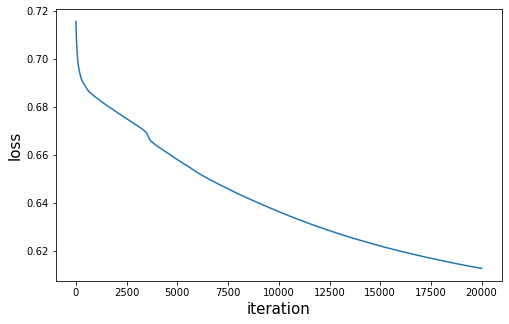

In [86]:
plt.figure(figsize = (8,5))
plt.plot(loss_record)
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.show()

In [87]:
acc = accuracy(x_train, y_train).numpy()
print("Accuracy: %s" % (acc*100))

Accuracy: 70.81339955329895


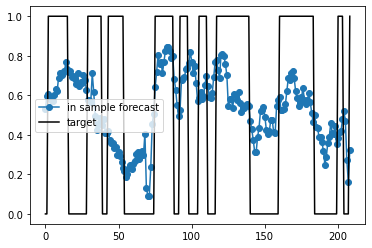

In [88]:
in_sample= build_model(x_train)

plt.plot(in_sample, 'o-', label='in sample forecast')
plt.plot(y_train, 'k-',   label='target')
plt.legend()
plt.show()

### 학습에 활용되지 않는 test data를 가지고 성과 평가

In [89]:
for step in range(training_steps):
    
    train(x_test, y_test)
    
    if step % display_step == 0:
        pred = build_model(x_test)
        loss = cost(pred, y_test) 
        acc  = accuracy(x_test, y_test)
        print("%s \t cost = %s \t accuracy = %f" % (step, loss.numpy(), acc.numpy()))

0 	 cost = 1.4903286 	 accuracy = 0.272727
2000 	 cost = 0.0029461486 	 accuracy = 1.000000
4000 	 cost = 0.00135893 	 accuracy = 1.000000
6000 	 cost = 0.0008656945 	 accuracy = 1.000000
8000 	 cost = 0.0006290004 	 accuracy = 1.000000
10000 	 cost = 0.0004911015 	 accuracy = 1.000000
12000 	 cost = 0.0004012887 	 accuracy = 1.000000
14000 	 cost = 0.00033830886 	 accuracy = 1.000000
16000 	 cost = 0.0002918752 	 accuracy = 1.000000
18000 	 cost = 0.0002562324 	 accuracy = 1.000000
20000 	 cost = 0.00022805027 	 accuracy = 1.000000


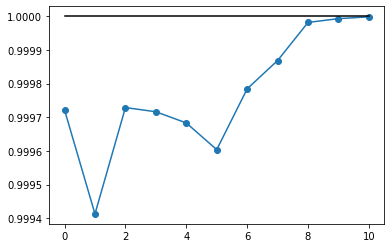

In [90]:
pred = build_model(x_test)

plt.plot(pred, 'o-', label='out of sample forecast')
plt.plot(y_test, 'k-', label='true values')
plt.show()

### 신규 데이터의 변수들이 앞으로 어떨 것으로 가정했을 때 <br> 앞으로 경제는 호황에 가까울지, 불황국면으로 갈 가능성이 높은지 예측

In [97]:
print(x_test.shape, y_test.shape)

(1, 6) (1, 1)


In [104]:
# Prediction
def predict(X):
    hypo = build_model(X)
    return tf.cast(hypo > 0.5, dtype=tf.float32)

x_test = np.array([[-0.123503, -0.415542,  0. , -0.306405,  0.605372,  1.015847]],
                   dtype=np.float32)
y_test = np.array([[1.]], dtype=np.float32)

x_test_predict = predict(x_test).numpy()
print("prob    : \n %s" % build_model(x_test).numpy())
print("predict : \n %s" % x_test_predict)

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,6], In[1]: [7,7] [Op:MatMul]